<a href="https://colab.research.google.com/github/Hennakhan/CEM-Website/blob/master/Islamophobia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [ ]:
!nvidia-smi

Thu Sep 10 13:43:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 47kB/s 


In [ ]:
!pip install --upgrade grpcio

     |████████████████████████████████| 3.8MB 11.1MB/s 
  Found existing installation: grpcio 1.31.0
    Uninstalling grpcio-1.31.0:
      Successfully uninstalled grpcio-1.31.0


In [ ]:
!pip install tqdm

In [ ]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 5.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=b06fc132273458cdd9e723e0325f86c47cd102e622e390652d9a0108f2117499
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=03a9d41a29a0332e3cb9a165fc15f8e04f376eeca229136146e081e9e7f0dd7b
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=ce37584d1f2ccedc919aebc43821fcf65bf49df308f51850c2ed5c4f9c35bfc1
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 10.0MB/s 


In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [ ]:
!gdown --id 1IFaDhhg0qQDjH7X0BfQDYanoKIDLlW0N --output data-task1.csv

Downloading...
From: https://drive.google.com/uc?id=1IFaDhhg0qQDjH7X0BfQDYanoKIDLlW0N
To: /content/data-task1.csv
100% 1.08M/1.08M [00:00<00:00, 71.1MB/s]


In [ ]:
df = pd.read_csv('data-task1.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

In [ ]:
# train = pd.read_csv("train.csv")
# valid = pd.read_csv("valid.csv")
# test = pd.read_csv("test.csv")

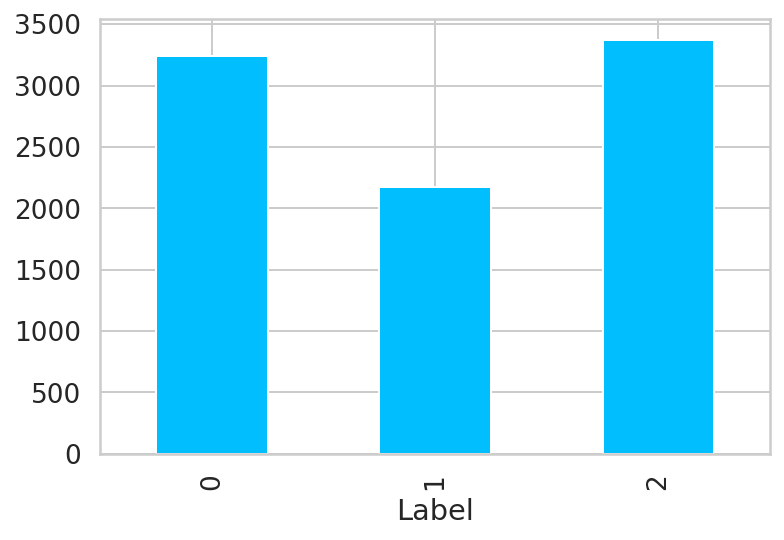

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [ ]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3374
0    3245
1    2174
Name: Label, dtype: int64

In [ ]:
# data = df

Data Preprocessing

In [ ]:
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceFourColon(x))

In [ ]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Text'] = df['Text'].apply(lambda x: textPattern(x))

In [ ]:
from sklearn.model_selection import train_test_split
data_train, test = train_test_split(df, test_size=0.20, random_state=42)

In [ ]:
train, valid = train_test_split(data_train, test_size=0.10, random_state=42)

In [ ]:
train = train.append(valid).reset_index(drop=True)

In [ ]:
train.head()

,Text,Label
0,Chinese companies quit Indian cricket,0
1,AshokShrivasta6 ndtv the channel which you se...,2
2,ArnabKGoswami sudhirchaudhary Mumbai Police Zi...,0
3,,2
4,Wow dada vigorous zindabad,0


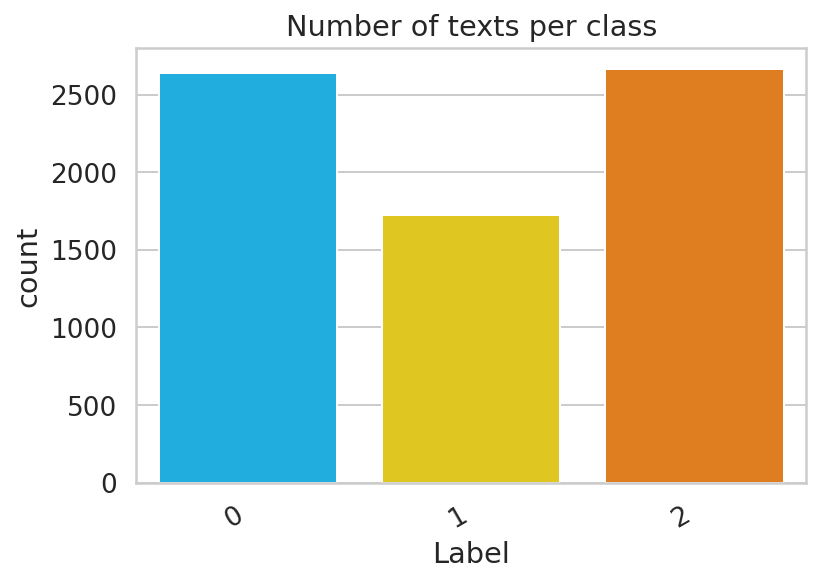

In [ ]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Islamophhobia Detection with BERT


In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-10 14:01:32--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c03::80, 2404:6800:4003:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  69.6MB/s    in 6.0s    

2020-09-10 14:01:39 (65.2 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model", exist_ok=True)

In [ ]:
!mv uncased_L-12_H-768_A-12/ model

In [ ]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [ ]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [ ]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

7034it [00:02, 3130.37it/s]
1759it [00:00, 3187.88it/s]


max seq_len 135


In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f15e0b857f0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

## Evaluation

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir log

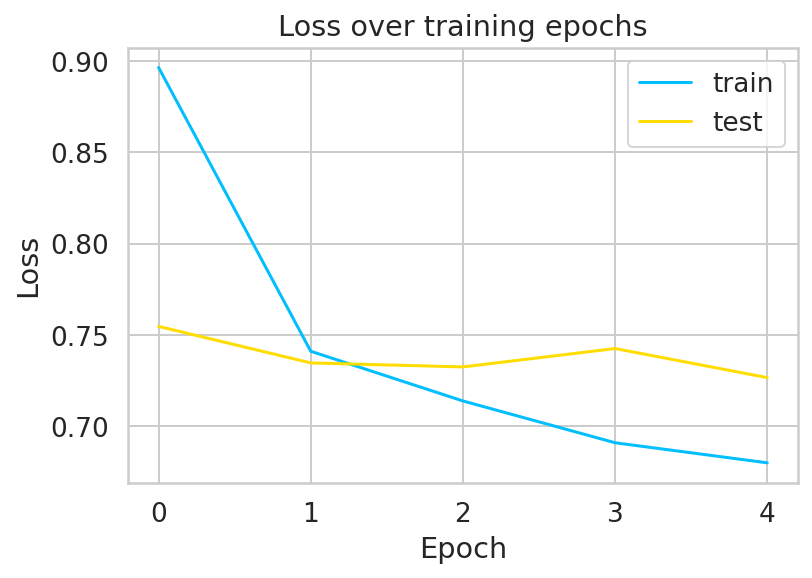

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

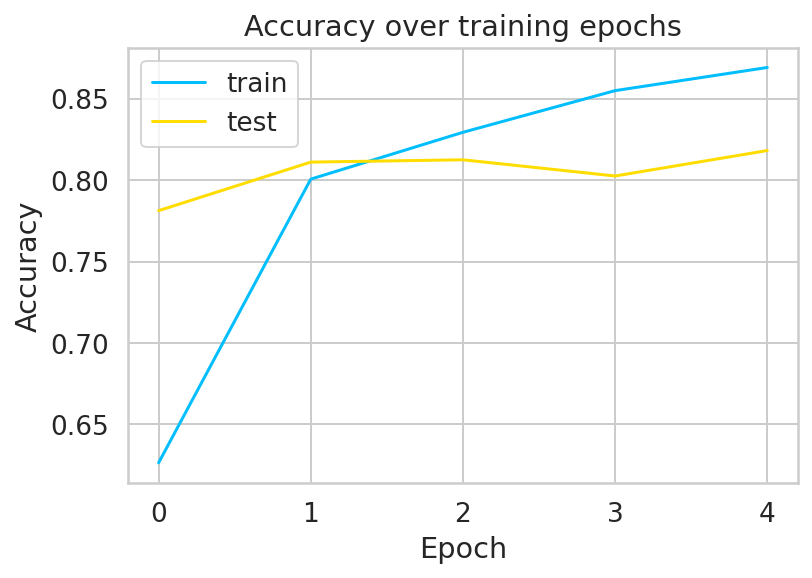

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

55/55 [==============================] - 17s 303ms/step - loss: 0.7352 - acc: 0.8101
train acc 0.8848450183868408
test acc 0.8101193904876709


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       604
           1       0.83      0.80      0.82       706
           2       0.86      0.80      0.83       449

    accuracy                           0.81      1759
   macro avg       0.82      0.81      0.81      1759
weighted avg       0.81      0.81      0.81      1759



In [ ]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

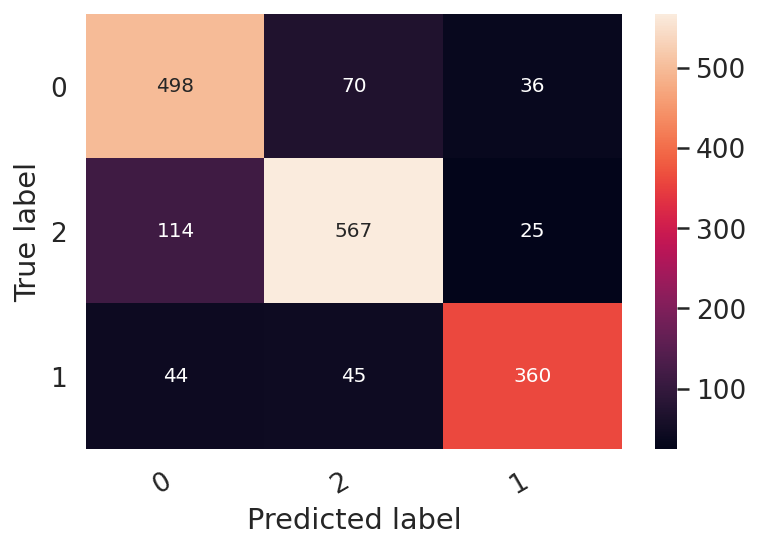

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [67]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
Mean_score = []
max_val = []
min_val = []
SE = []
Mean_per = []

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    random_shuff = random.randint(1,6000)
    print('Fold ', i+1,'Random number for split', random_shuff)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True, random_state=random_shuff)
    # Splitting train data further into train and validate
    # train, valid = train_test_split(data_training, test_size=0.10, random_state=random_shuff)
    # train = train.append(valid).reset_index(drop=True)
    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


333it [00:00, 3326.09it/s]

BERT: 
Fold  1 Random number for split 1733



7913it [00:02, 3163.13it/s]
880it [00:00, 3034.12it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 294s 659ms/step - loss: 0.7744 - acc: 0.7693 - val_loss: 0.6800 - val_acc: 0.8674
Epoch 2/5
446/446 [==============================] - 293s 658ms/step - loss: 0.6899 - acc: 0.8587 - val_loss: 0.6790 - val_acc: 0.8687
Epoch 3/5
446/446 [==============================] - 292s 654ms/step - loss: 0.6755 - acc: 0.8721 - val_loss: 0.6698 - val_acc: 0.8763
Epoch 4/5
446/446 [==============================] - 292s 655ms/step - loss: 0.6676 - acc: 0.8813 - val_loss: 0.6787 - val_acc: 0.8674
Epoch 5/5
28/28 [==============================] - 8s 293ms/step - loss: 0.6908 - acc: 0.8580


332it [00:00, 3316.95it/s]

Fold  2 Random number for split 2395



7913it [00:02, 3340.75it/s]
880it [00:00, 3382.05it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 292s 654ms/step - loss: 0.9965 - acc: 0.5439 - val_loss: 0.9388 - val_acc: 0.5896
Epoch 2/5
446/446 [==============================] - 292s 654ms/step - loss: 0.6869 - acc: 0.8586 - val_loss: 0.6662 - val_acc: 0.8838
Epoch 3/5
446/446 [==============================] - 292s 654ms/step - loss: 0.6616 - acc: 0.8848 - val_loss: 0.6593 - val_acc: 0.8927
Epoch 4/5
446/446 [==============================] - 292s 654ms/step - loss: 0.6550 - acc: 0.8923 - val_loss: 0.6644 - val_acc: 0.8864
Epoch 5/5
28/28 [==============================] - 8s 294ms/step - loss: 0.6490 - acc: 0.9011


292it [00:00, 2915.44it/s]

Fold  3 Random number for split 3469



7913it [00:02, 3295.98it/s]
880it [00:00, 3190.71it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 293s 656ms/step - loss: 0.8855 - acc: 0.6568 - val_loss: 0.6622 - val_acc: 0.8876
Epoch 2/5
446/446 [==============================] - 294s 659ms/step - loss: 0.6561 - acc: 0.8907 - val_loss: 0.6593 - val_acc: 0.8902
Epoch 3/5
446/446 [==============================] - 293s 657ms/step - loss: 0.6453 - acc: 0.9037 - val_loss: 0.6519 - val_acc: 0.8977
Epoch 4/5
446/446 [==============================] - 293s 657ms/step - loss: 0.6484 - acc: 0.8995 - val_loss: 0.6676 - val_acc: 0.8813
Epoch 5/5
28/28 [==============================] - 8s 294ms/step - loss: 0.6404 - acc: 0.9080


246it [00:00, 2455.40it/s]

Fold  4 Random number for split 1647



7913it [00:02, 3257.38it/s]
880it [00:00, 3387.89it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 293s 658ms/step - loss: 0.8975 - acc: 0.6450 - val_loss: 0.8334 - val_acc: 0.7020
Epoch 2/5
446/446 [==============================] - 293s 657ms/step - loss: 0.6731 - acc: 0.8747 - val_loss: 0.6267 - val_acc: 0.9242
Epoch 3/5
446/446 [==============================] - 293s 657ms/step - loss: 0.6446 - acc: 0.9065 - val_loss: 0.6246 - val_acc: 0.9268
Epoch 4/5
446/446 [==============================] - 293s 658ms/step - loss: 0.6420 - acc: 0.9066 - val_loss: 0.6336 - val_acc: 0.9179
Epoch 5/5
28/28 [==============================] - 8s 293ms/step - loss: 0.6461 - acc: 0.9023


264it [00:00, 2636.97it/s]

Fold  5 Random number for split 707



7913it [00:02, 3141.20it/s]
880it [00:00, 3219.21it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 293s 657ms/step - loss: 0.8876 - acc: 0.6606 - val_loss: 0.6327 - val_acc: 0.9028
Epoch 2/5
446/446 [==============================] - 293s 657ms/step - loss: 0.6396 - acc: 0.9083 - val_loss: 0.6191 - val_acc: 0.9331
Epoch 3/5
446/446 [==============================] - 293s 658ms/step - loss: 0.6422 - acc: 0.9066 - val_loss: 0.6185 - val_acc: 0.9331
Epoch 4/5
446/446 [==============================] - 293s 658ms/step - loss: 0.6360 - acc: 0.9120 - val_loss: 0.6306 - val_acc: 0.9205
Epoch 5/5
28/28 [==============================] - 8s 294ms/step - loss: 0.6464 - acc: 0.9000


314it [00:00, 3136.55it/s]

Fold  6 Random number for split 1669



7913it [00:02, 3305.72it/s]
880it [00:00, 3260.12it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 293s 657ms/step - loss: 0.8022 - acc: 0.7458 - val_loss: 0.6434 - val_acc: 0.9066
Epoch 2/5
446/446 [==============================] - 292s 656ms/step - loss: 0.6450 - acc: 0.9049 - val_loss: 0.6791 - val_acc: 0.8699
Epoch 3/5
446/446 [==============================] - 293s 658ms/step - loss: 0.6423 - acc: 0.9054 - val_loss: 0.6492 - val_acc: 0.9003
Epoch 4/5
446/446 [==============================] - 293s 657ms/step - loss: 0.6437 - acc: 0.9065 - val_loss: 0.6515 - val_acc: 0.9003
Epoch 5/5
28/28 [==============================] - 8s 293ms/step - loss: 0.6418 - acc: 0.9080


300it [00:00, 2996.53it/s]

Fold  7 Random number for split 2518



7913it [00:02, 3246.09it/s]
880it [00:00, 3285.18it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 294s 659ms/step - loss: 1.0797 - acc: 0.4668 - val_loss: 0.6322 - val_acc: 0.9192
Epoch 2/5
446/446 [==============================] - 294s 659ms/step - loss: 0.6452 - acc: 0.9063 - val_loss: 0.6295 - val_acc: 0.9217
Epoch 3/5
446/446 [==============================] - 295s 661ms/step - loss: 0.6393 - acc: 0.9118 - val_loss: 0.6333 - val_acc: 0.9167
Epoch 4/5
446/446 [==============================] - 295s 661ms/step - loss: 0.6553 - acc: 0.8950 - val_loss: 0.6360 - val_acc: 0.9154
Epoch 5/5
28/28 [==============================] - 8s 293ms/step - loss: 0.6497 - acc: 0.8977


312it [00:00, 3112.22it/s]

Fold  8 Random number for split 529



7913it [00:02, 3237.02it/s]
880it [00:00, 3335.56it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 295s 662ms/step - loss: 0.8125 - acc: 0.7332 - val_loss: 0.6355 - val_acc: 0.9167
Epoch 2/5
446/446 [==============================] - 295s 661ms/step - loss: 0.6421 - acc: 0.9066 - val_loss: 0.6429 - val_acc: 0.8914
Epoch 3/5
446/446 [==============================] - 296s 663ms/step - loss: 0.6368 - acc: 0.9098 - val_loss: 0.6302 - val_acc: 0.9230
Epoch 4/5
446/446 [==============================] - 296s 663ms/step - loss: 0.6325 - acc: 0.9141 - val_loss: 0.6310 - val_acc: 0.9242
Epoch 5/5
28/28 [==============================] - 8s 294ms/step - loss: 0.6404 - acc: 0.9091


274it [00:00, 2738.77it/s]

Fold  9 Random number for split 1585



7913it [00:02, 3131.83it/s]
880it [00:00, 3240.45it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 297s 665ms/step - loss: 0.8737 - acc: 0.6708 - val_loss: 0.6209 - val_acc: 0.9306
Epoch 2/5
446/446 [==============================] - 297s 666ms/step - loss: 0.6348 - acc: 0.9141 - val_loss: 0.6194 - val_acc: 0.9306
Epoch 3/5
446/446 [==============================] - 296s 664ms/step - loss: 0.6308 - acc: 0.9183 - val_loss: 0.6196 - val_acc: 0.9306
Epoch 4/5
446/446 [==============================] - 295s 663ms/step - loss: 0.6258 - acc: 0.9235 - val_loss: 0.6219 - val_acc: 0.9293
Epoch 5/5
28/28 [==============================] - 8s 294ms/step - loss: 0.6372 - acc: 0.9102


311it [00:00, 3105.05it/s]

Fold  10 Random number for split 3719



7913it [00:02, 3221.91it/s]
880it [00:00, 3086.76it/s]


max seq_len 135
Epoch 1/5
446/446 [==============================] - 296s 665ms/step - loss: 1.0509 - acc: 0.4978 - val_loss: 0.9972 - val_acc: 0.5505
Epoch 2/5
446/446 [==============================] - 296s 664ms/step - loss: 0.8097 - acc: 0.7388 - val_loss: 0.6279 - val_acc: 0.9205
Epoch 3/5
446/446 [==============================] - 296s 663ms/step - loss: 0.6329 - acc: 0.9160 - val_loss: 0.6332 - val_acc: 0.9154
Epoch 4/5
446/446 [==============================] - 296s 663ms/step - loss: 0.6320 - acc: 0.9163 - val_loss: 0.6271 - val_acc: 0.9192
Epoch 5/5
28/28 [==============================] - 8s 294ms/step - loss: 0.6135 - acc: 0.9364


In [69]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9030681818181818
 Mean testing accuracy for 10 folds: 0.9030681848526001


In [71]:
sentences = [
  "Play our song now you asshole jehadi muslim",
  "Rate this book as awful"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "Label:", classes[label])
  print()

text: Play our song now you asshole jehadi muslim Label: 2

text: Rate this book as awful Label: 0

